In [1]:
from torch.nn.functional import pad
import torch.nn.functional as F
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline

In [2]:
def Projection2D_batch(data3d, batch_size=100):
    """
    Genearting 2D projections from cone beam geometry with batching in the angles
    data3d in shape of nz, nx, ny
    """
    # to store multi-angle projections
    proj_tot = []
    
    data3d.requires_grad_()
    
    # batching for the angle
    for i in range(nProj // batch_size + 1):
        # genearting affine grids for sample rotation
        angle_rad = deg[i * batch_size:(i+1) * batch_size] / 360 * 2 * np.pi
        angle_rad = angle_rad.unsqueeze(-1).unsqueeze(-1)

        uu, vv = torch.meshgrid(us, vs)
        uu, vv = uu.T, vv.T
        xx, yy = torch.meshgrid(xs, ys)
        xx, yy = xx.T, yy.T

        rx = (xx * torch.cos(angle_rad) - yy * torch.sin(angle_rad)) / dx / nx * 2
        ry = (xx * torch.sin(angle_rad) + yy * torch.cos(angle_rad)) / dy / ny * 2

        if GPU:
            rx = rx.to(device='cuda:0')
            ry = ry.to(device='cuda:0')

        # rxry in (batch, rx, ry, 2)
        rxry = torch.stack((rx, ry), -1)

        # using bilinear interpolation to sample the rotated objects
        # expand the data3d in the batch dimension without consuming GPU memory
        # data3d_new in shape of (batch, nz, nx, ny)
        data3d_new = F.grid_sample(data3d.unsqueeze(0).expand(len(angle_rad), nz, nx, ny), rxry, 
                           mode='bilinear', padding_mode='zeros', align_corners=True)

        # generate sampling grid in xs and zs for cone beam
        xx, zz = torch.meshgrid(xs, zs)
        xx, zz = xx.T, zz.T

        Ratio = (ys + DSO) / DSD
        # to do broadcasting later on
        Ratio = Ratio.unsqueeze(-1).unsqueeze(-1)

        pu, pv = uu * Ratio, vv * Ratio
        pu, pv = (pu) / dx / nx * 2, (pv) / dz / nz * 2
        pu, pv = pu.to(torch.float32), pv.to(torch.float32)

        if GPU:
            pv = pv.to(device='cuda:0')
            pu = pu.to(device='cuda:0')

        # pupv in (ny, nu, nv, 2)
        pupv = torch.stack((pu, pv), -1)

        # permute data3d from (batch, nz, nx, ny) to (ny, batch, nz, nx)
        # to process all the ny elements
        data3d_new = data3d_new.permute(3, 0, 1, 2)
        temp = F.grid_sample(data3d_new, pupv, 
                             mode='bilinear', padding_mode='zeros', align_corners=True)

        # sum in ny to produce the 2d projections
        # then transpose to  (batch, nx, nz)
        proj2d = torch.sum(temp, dim=[0])
        proj2d = proj2d.permute(0, 2, 1)

        dist = torch.sqrt(DSD**2 + uu**2 + vv**2) / DSD * dy

        if GPU:
            dist = dist.to(device='cuda:0')
        # multiple the distance matrix
        proj2d = proj2d * dist.T
        
        proj_tot.append(proj2d)
    # concat alone the batch dimension to get all the projections
    proj_tot = torch.cat(proj_tot, dim=0)

    return proj_tot

In [3]:
def reconstruct(projections, resolution, lr, iterations, batch_size, 
                loss_func=torch.nn.MSELoss(), optimizer='Adam', GPU=False, schedule=True):
    """Performs a full reconstruction based on gradient descent
    """
    
    # We start from a uniform image as our initial guess
    #im = torch.ones((resolution[0], resolution[1], resolution[2]), requires_grad=True, device='cuda:0')
    #im = torch.zeros((resolution[0], resolution[1], resolution[2]))
    im = loadmat('./FBP-256/FDK-scratch-' + str(2**(SKIP-1)) + '.mat')['Reconimg'][:, :, :]
    im = torch.from_numpy(im).permute(2, 0, 1)

    if GPU:
        im = im.to(device='cuda:0')
        projections = projections.to(device='cuda:0')

    if 'Adam'.lower() in optimizer.lower():
        t_optimizer = torch.optim.Adam([im], lr=lr)
    elif 'LBFGS'.lower() in optimizer.lower():
        t_optimizer = torch.optim.LBFGS([im], lr=lr, history_size=2, 
                                        tolerance_grad=1e-11, tolerance_change=1e-11, max_iter=10)
    elif 'sgd'.lower() in optimizer.lower():
        t_optimizer = torch.optim.SGD([im], lr=lr, momentum=True)

    if schedule:
        scheduler = torch.optim.lr_scheduler.StepLR(t_optimizer, step_size=50, gamma=0.5)

    def closure():
        t_optimizer.zero_grad()
        projected = Projection2D_batch(im, batch_size=batch_size)
        l = loss_func(projected, projections)
        l.backward()
        return l

    loss = []
    results = []
    for i in tqdm(range(iterations)):
        tensor = t_optimizer.step(closure)
        tensor = tensor.detach().cpu().numpy()
        loss.append(tensor[()])
        
        if schedule:
            scheduler.step()
            
        with torch.no_grad():
            im.clamp_(min=0, max=1)
        
        result = im.detach()
        results.append(np.array(result.to(device='cpu')))
    
    #if GPU:
    #    results = results.to(device='cpu')

    return results, loss

In [4]:
# using GPU?
GPU = True

# define number of object voxels
nx, ny, nz = 256, 256, 10

# object real size in mm
sx, sy, sz = 5, 5, 0.05

# real detector pixel density
nu, nv = 254, 20

# detector real size in mm
su, sv = 5, 0.1

# single voxel size
dx, dy, dz, du, dv = sx/nx, sy/ny, sz/nz, su/nu, sv/nv

# Geometry calculation
xs = torch.arange(-(nx -1) / 2, nx / 2, 1) * dx
ys = torch.arange(-(ny -1) / 2, ny / 2, 1) * dy
zs = torch.arange(-(nz -1) / 2, nz / 2, 1) * dz

us = torch.arange(-(nu -1) / 2, nu / 2, 1) * du
vs = torch.arange(-(nv -1) / 2, nv / 2, 1) * dv

# source to detector, and source to object axis distances in mm
DSD, DSO = 74.11, 55.07

In [5]:
#recon_tot = []
#loss_tot = []

for SKIP in range(1, 10):
    
    # angle setting
    #skip = 1
    direction = 1 # clock wise/ counter clockwise
    start = 0.
    end = 360.
    step = 0.225 * 2**(SKIP-1)
    deg = direction * torch.arange(start, end+0.225, step)
    nProj = len(deg)
    print(nProj)
    
    # load data
    projections = loadmat('projections-scratch.mat')['projections']
    projections = np.transpose(projections, (0, 2, 1))
    projections = projections[::2**(SKIP-1), :, :]
    print(np.shape(projections))
    
    recon, loss = reconstruct(torch.from_numpy(projections).to(torch.float32), [nz, nx, ny], lr=0.01, iterations=100,
                batch_size=nProj, loss_func=torch.nn.MSELoss(), optimizer='Adam', GPU=True, schedule=True)
    
    np.save('iter-scratch-recon-' + str(SKIP) + '.npy', recon)
    
    #recon_tot.append(recon)
    #loss_tot.append(loss)

1601
(1601, 254, 20)


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

801
(801, 254, 20)


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

401
(401, 254, 20)


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

201
(201, 254, 20)


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

101
(101, 254, 20)


  2%|█▋                                                                                | 2/100 [00:00<00:06, 15.79it/s]

51
(51, 254, 20)


  3%|██▍                                                                               | 3/100 [00:00<00:03, 26.86it/s]

26
(26, 254, 20)


  4%|███▎                                                                              | 4/100 [00:00<00:02, 34.58it/s]

13
(13, 254, 20)


  4%|███▎                                                                              | 4/100 [00:00<00:02, 37.13it/s]

7
(7, 254, 20)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.16it/s]


In [13]:
Xs, Ys = np.mgrid[:174,:174]
Xs = Xs - np.mean(Xs)
Ys = Ys - np.mean(Ys)
Rs = np.sqrt(Xs**2 + Ys**2)

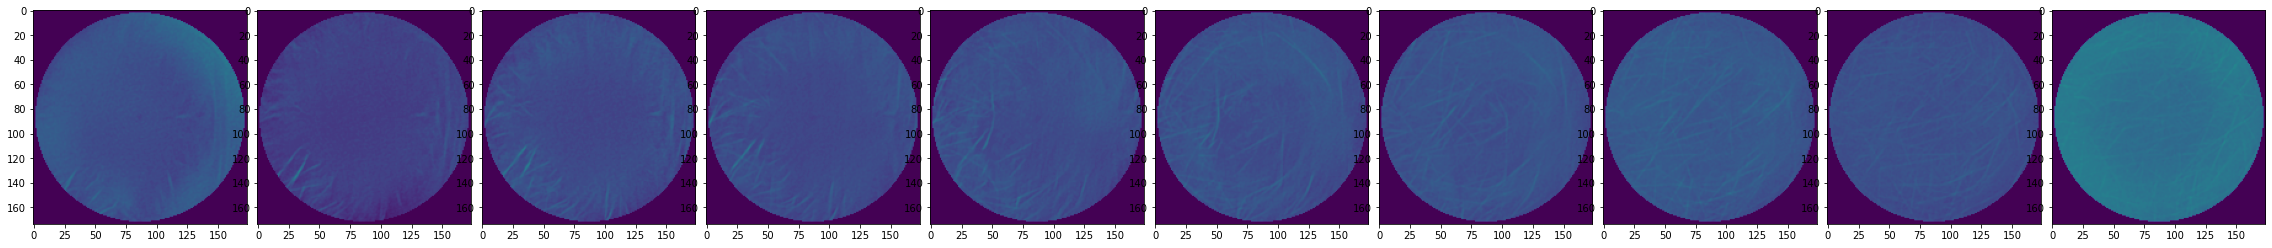

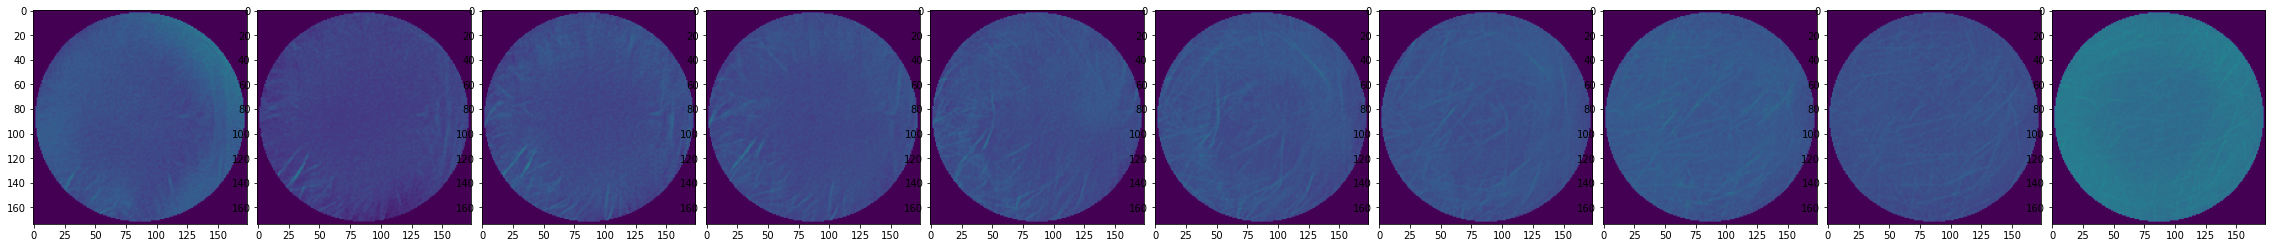

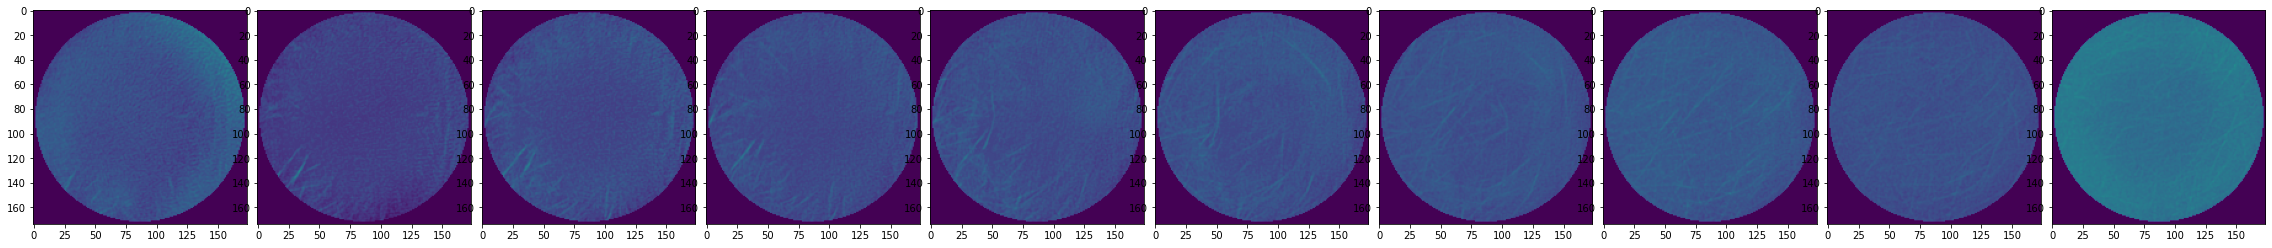

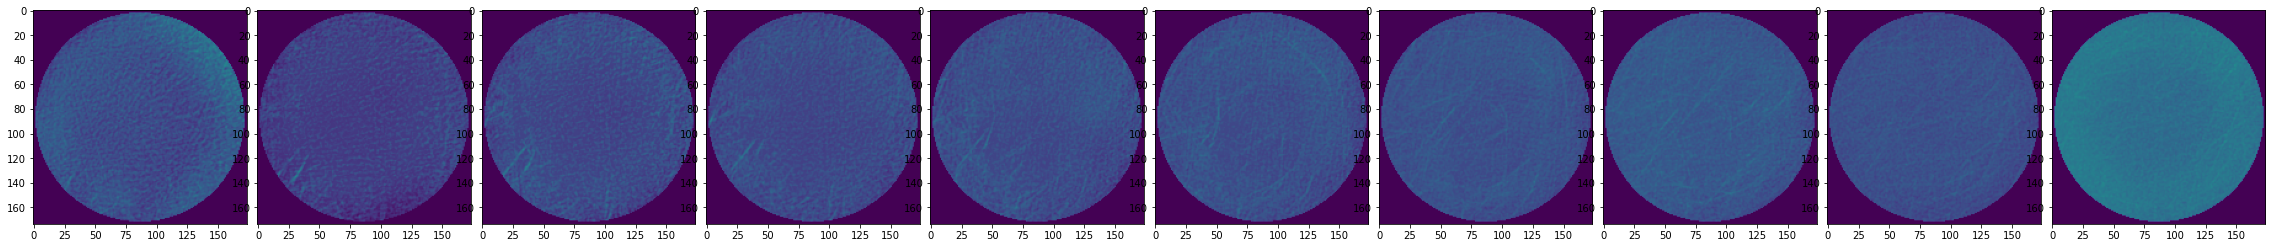

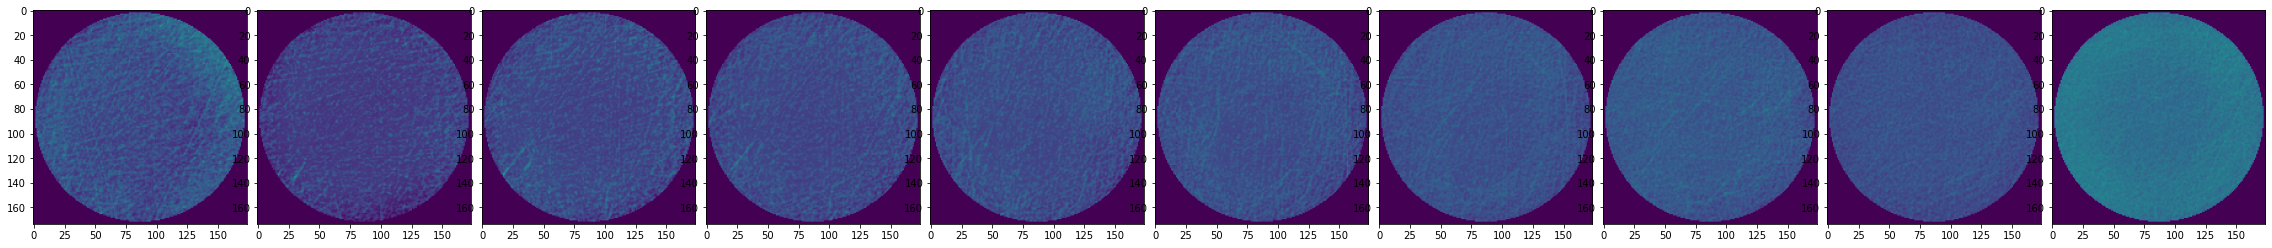

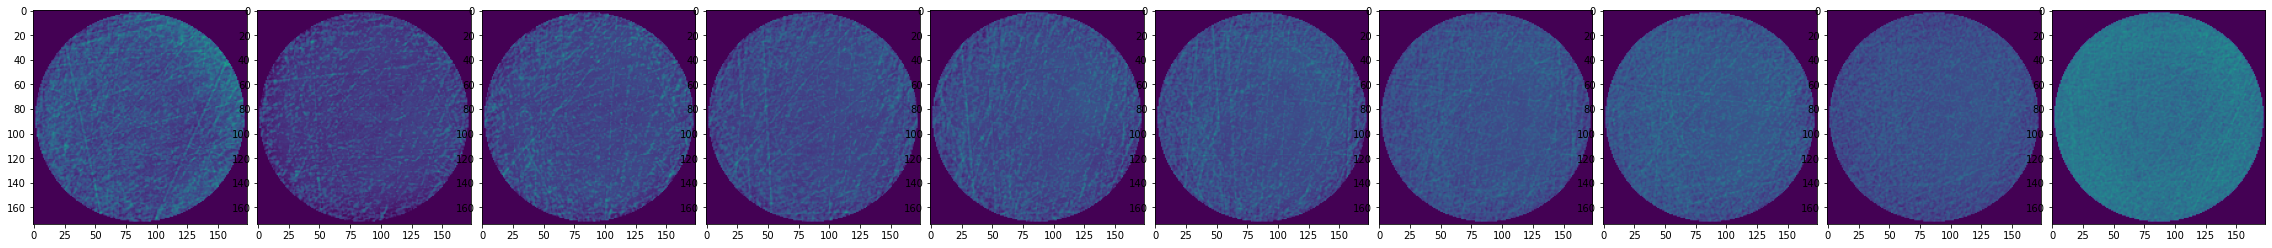

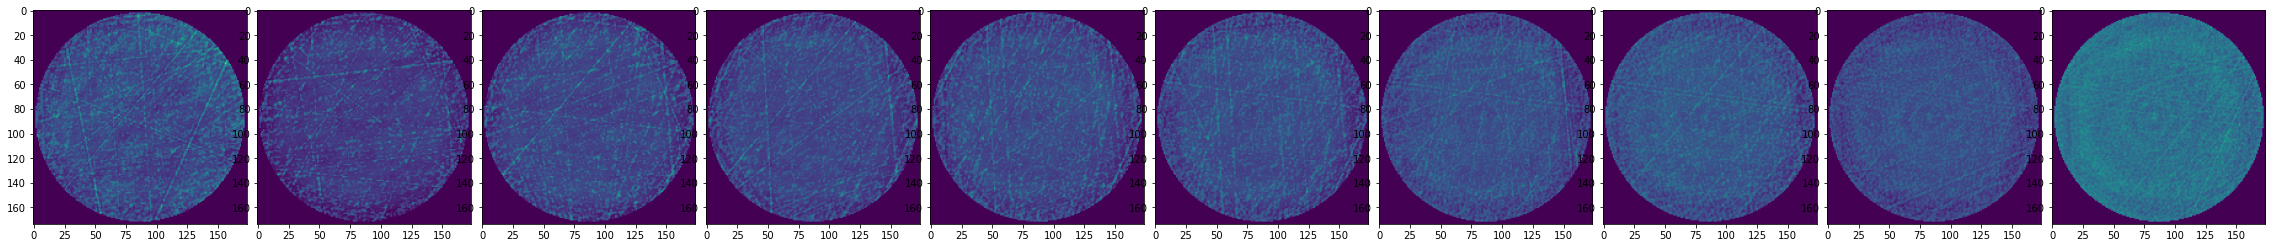

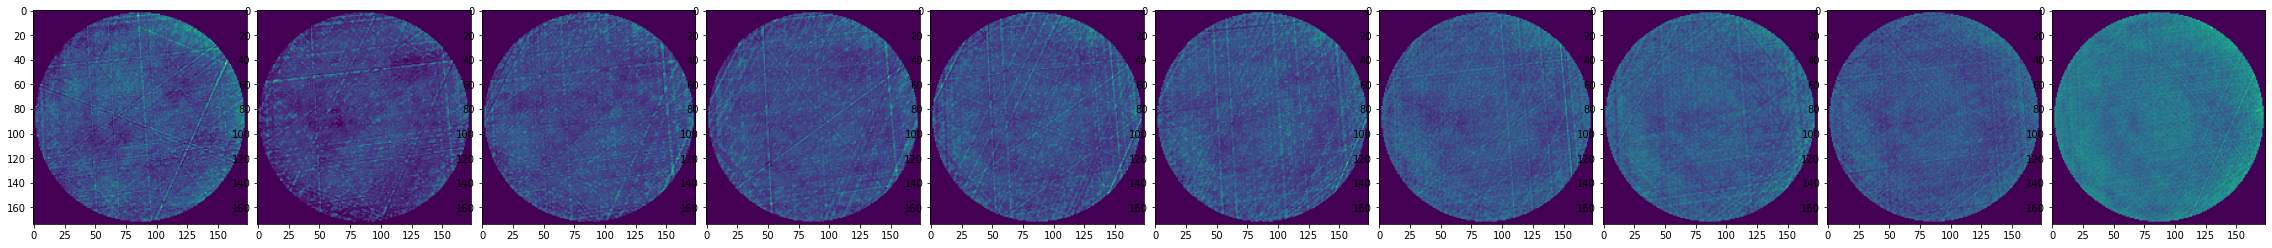

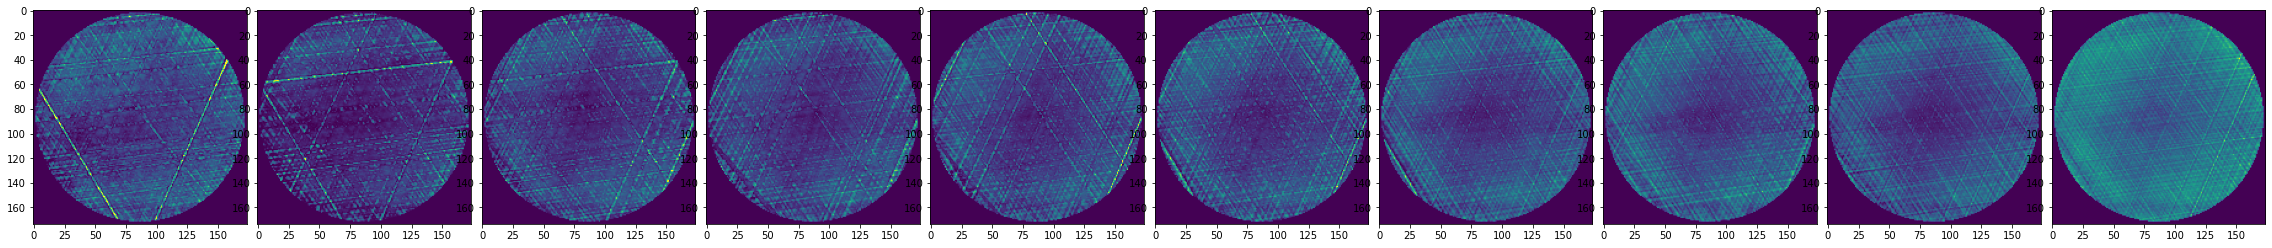

In [14]:
for SKIP in range(1, 10):
    
    recon = np.load('iter-scratch-recon-' + str(SKIP) + '.npy')[-1][:, 36+5:-36-5, 36+5:-36-5]
    recon[:, Rs>85] = 0 

    plt.rcParams['figure.figsize'] = [40, 40*10]
    fig = plt.figure()
    fig.subplots_adjust(hspace=.05, wspace=.05)

    for i in range(10):
        ax = fig.add_subplot(1, 10, i +1)
        plt.imshow(recon[i])
        plt.clim(0, 0.5)